In [2]:
from diffusion_curvature.datasets import torus
import graphtools
import matplotlib.pyplot as plt
import numpy as np
import torch


In [37]:
X_torus, torus_gaussian_curvature = torus(n=5000)
G_torus = graphtools.Graph(X_torus, anisotropy=1, knn=30)

In [38]:
from diffusion_curvature.graphtools import DiffusionCurvature
DC = DiffusionCurvature(t=12)

In [39]:
torus_gaussian_curvature.shape

(2493,)

In [40]:
X_torus.shape

(2493, 3)

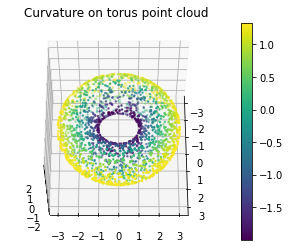

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_torus[:, 0], X_torus[:, 1], X_torus[:, 2], s=2, c = torus_gaussian_curvature)
ax.set_title("Curvature on torus point cloud")
ax.view_init(60, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [3]:
from diffusion_curvature.manifold_graph import ManifoldGraph, diffusion_curvature, diffusion_entropy_curvature, entropy_of_diffusion, wasserstein_spread_of_diffusion, power_diffusion_matrix, phate_distances
from diffusion_curvature.kernels import gaussian_kernel
import numpy as np

In [4]:
def generate_torus_point_cloud(num_points = 5000, R = 3, r = 1):
    # Generate random angles for theta and phi
    theta = np.random.uniform(0, 2*np.pi, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)

    # Compute the torus points
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)

    K = np.cos(phi)/(r * (R + r * np.cos(phi))) 

    return np.column_stack((x, y, z)), K

# Create torus parameters
R = 1 # Major radius
r = 0.375  # Minor radius
num_samples = 5000

# Generate a sphere point cloud with 1000 points and radius 1
X_torus, torus_K = generate_torus_point_cloud(num_points = num_samples, R = R, r = r)

In [5]:
A = gaussian_kernel(X_torus, kernel_type="adaptive", k = 20, anisotropic_density_normalization=1)
np.fill_diagonal(A,0)
# initialize the manifold graph; input your computed dimension along with the adjacency matrix
G_pure = ManifoldGraph(A = A, dimension=2, anisotropic_density_normalization=1)



In [6]:
G_pure = diffusion_curvature(G_pure, t=8)
ks_entropy = entropy_of_diffusion(G_pure)

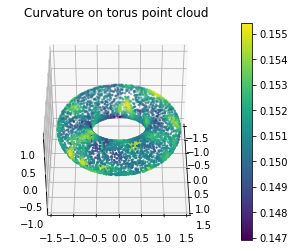

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_torus[:, 0], X_torus[:, 1], X_torus[:, 2], s=2, c = 1/ks_entropy)
ax.set_title("Curvature on torus point cloud")
ax.view_init(40, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [34]:
from scipy.stats import pearsonr

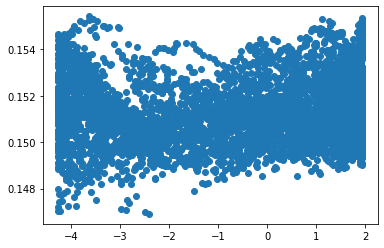

In [8]:
plt.scatter(torus_K, 1/ks_entropy)

In [ ]:
corr, _ = pearsonr(torus_K, G_pure.ks)
corr